In [65]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

In [67]:
n = 2   # length of n-gram
dir = f"{n}grams"
infogain_file_prefix = f"{n}gram_info"
train_data_file = f"{n}grams/{n}gram_presence_train.csv"
test_data_file = f"{n}grams/{n}gram_presence_test.csv"

In [68]:
n_best = 1000 # number of best ngrams to keep

In [69]:
files = [file for file in sorted(os.walk(dir))[0][2] if infogain_file_prefix in file]
files

['2gram_info_gain_2021-04-29_08-40-21.csv',
 '2gram_info_gain_2021-04-29_08-57-08.csv',
 '2gram_info_gain_2021-04-29_09-23-09.csv',
 '2gram_info_gain_2021-04-29_09-38-25.csv',
 '2gram_info_gain_2021-04-30_06-11-54.csv',
 '2gram_info_gain_2021-04-30_06-28-12.csv',
 '2gram_info_gain_2021-04-30_06-39-51.csv',
 '2gram_info_gain_2021-04-30_06-55-27.csv',
 '2gram_info_gain_2021-04-30_07-38-03.csv',
 '2gram_info_gain_2021-04-30_07-49-52.csv',
 '2gram_info_gain_2021-04-30_07-59-40.csv',
 '2gram_info_gain_2021-04-30_08-01-56.csv',
 '2gram_info_gain_2021-04-30_08-09-51.csv',
 '2gram_info_gain_2021-04-30_07-07-28.csv']

In [70]:
ngrams = []
infogains = []
for file in files:
    with open("2grams/" + file) as f:
        lines = f.read().splitlines()
        ngrams += lines[0].split(",")
        infogains += [float(num) for num in lines[1].split(",")]

In [71]:
infogains_sorted = sorted(infogains)
threshold = infogains_sorted[-n_best-1]
ngrams_best = []

for infogain, ngram in zip(infogains, ngrams):
    if infogain > threshold:
        ngrams_best.append(ngram)

In [72]:
len(ngrams_best)

1000

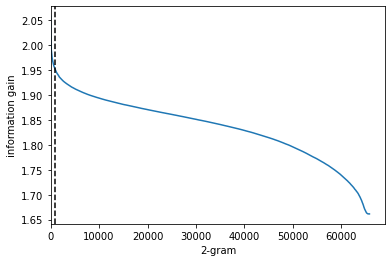

In [73]:
plt.plot(infogains_sorted[::-1])
plt.xlim([0, None])
plt.xlabel("2-gram")
plt.ylabel("information gain")
plt.axvline(n_best, ls="dashed", c="k")

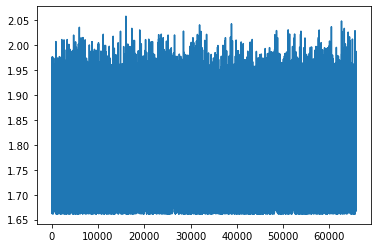

In [74]:
plt.plot(infogains)

In [75]:
dataset = pd.read_csv(train_data_file, usecols=["file", "class"]+ngrams_best)
dataset.head()

,file,class,a3c4,bec1,4d79,f66d,5656,a7e1,f37e,f68a,...,6a57,9952,d8d8,5755,2b4e,5e5c,126a,df43,fe40,fcfc
0,02.exe,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,03.exe,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,04.exe,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,06.exe,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,07409496-a423-4a3e-b620-2cfb01a9318d_HyperV-Co...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
dataset.shape

(68042, 1002)

In [77]:
dataset_test = pd.read_csv(test_data_file, usecols=["file", "class"]+ngrams_best)
dataset_test.head()

,file,class,a3c4,bec1,4d79,f66d,5656,a7e1,f37e,f68a,...,6a57,9952,d8d8,5755,2b4e,5e5c,126a,df43,fe40,fcfc
0,1196707913.dll,0,0,0,1,0,1,0,1,1,...,0,0,0,1,0,1,1,0,1,1
1,1381388866.dll,0,0,0,1,1,1,0,1,1,...,0,0,0,1,0,0,1,0,1,1
2,1394Info.dll,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,64BitMAPIBroker.exe,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,7z.dll,0,1,1,0,1,0,1,0,1,...,0,0,1,0,1,1,1,1,1,1


In [78]:
dataset_test.shape

(9364, 1002)

In [79]:
print("Training benign:", len(dataset[dataset["class"]==0]))
print("Training malware:", len(dataset[dataset["class"]==1]))

print("Test benign:", len(dataset_test[dataset_test["class"]==0]))
print("Test malware:", len(dataset_test[dataset_test["class"]==1]))

Training benign: 17338
Training malware: 50704
Test benign: 2567
Test malware: 6797


In [80]:
X_train = dataset.drop('file', axis='columns').drop('class', axis='columns')
y_train = dataset['class']

X_test = dataset_test.drop('file', axis='columns').drop('class', axis='columns')
y_test = dataset_test['class']

In [87]:
param_grid_ = {'hidden_layer_sizes': [100, 500, 1000]
                #'learning_rate': ["constant", "invscaling"]
              }

kfold = KFold(n_splits=5, random_state=42, shuffle=True)

clf_base = MLPClassifier(random_state=41, max_iter=500)

grid_search = GridSearchCV(estimator=clf_base,
                            cv=kfold,
                            param_grid=param_grid_,
                            n_jobs=8,  # jobs to run in parallel
                            verbose=1,
                            scoring="balanced_accuracy")

grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_

# how does it decide which one is best?
print("Best estimator:")
print(clf)

y_pred = clf.predict(X_test)
score_acc = accuracy_score(y_test, y_pred)
score_prec = precision_score(y_test, y_pred)
score_rec = recall_score(y_test, y_pred)
score_auc = roc_auc_score(y_test, y_pred)
print("Accuracy:", score_acc)
print("Precision:", score_prec)
print("Recall:", score_rec)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator:
MLPClassifier(hidden_layer_sizes=500, max_iter=500, random_state=41)
Accuracy: 0.9604869713797523
Precision: 0.9615108430274307
Recall: 0.9849933794321024


In [89]:
clf = MLPClassifier(hidden_layer_sizes=1000, max_iter=500, random_state=41)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score_acc = accuracy_score(y_test, y_pred)
score_prec = precision_score(y_test, y_pred)
score_rec = recall_score(y_test, y_pred)
score_auc = roc_auc_score(y_test, y_pred)
print("Accuracy:", score_acc)
print("Precision:", score_prec)
print("Recall:", score_rec)

Accuracy: 0.9525843656557027
Precision: 0.9683031107179714
Recall: 0.9663086655877593


In [90]:
clf = MLPClassifier(hidden_layer_sizes=(1000,500), max_iter=500, random_state=41)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score_acc = accuracy_score(y_test, y_pred)
score_prec = precision_score(y_test, y_pred)
score_rec = recall_score(y_test, y_pred)
score_auc = roc_auc_score(y_test, y_pred)
print("Accuracy:", score_acc)
print("Precision:", score_prec)
print("Recall:", score_rec)

Accuracy: 0.9598462195642887
Precision: 0.9701273978620588
Recall: 0.974694718258055


In [91]:
clf = MLPClassifier(hidden_layer_sizes=500, max_iter=500, random_state=41)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score_acc = accuracy_score(y_test, y_pred)
score_prec = precision_score(y_test, y_pred)
score_rec = recall_score(y_test, y_pred)
score_auc = roc_auc_score(y_test, y_pred)
print("Accuracy:", score_acc)
print("Precision:", score_prec)
print("Recall:", score_rec)

Accuracy: 0.9604869713797523
Precision: 0.9615108430274307
Recall: 0.9849933794321024


decision tree
Accuracy: 0.9020717642033319
Precision: 0.9153715738909296
Recall: 0.9532146535236133

boosted decision tree
Accuracy: 0.9143528406663819
Precision: 0.9171885873347251
Recall: 0.9695453876710314

random forest
Accuracy: 0.9443613840239214
Precision: 0.9425952045133992
Recall: 0.9832278946594085

neural network
Accuracy: 0.9607005553182401
Precision: 0.9623184237019992
Recall: 0.9844048845078711



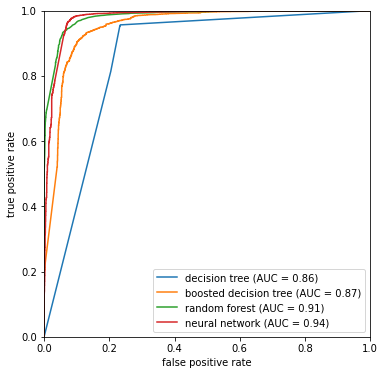

In [81]:
classifier_names = ['decision tree',
                    'boosted decision tree',
                    'random forest',
                    'neural network']
classifiers = [DecisionTreeClassifier(random_state=43),
               GradientBoostingClassifier(random_state=42),
               RandomForestClassifier(random_state=42),
               MLPClassifier(max_iter=500, random_state=41)]    # report: random_state=41

plt.figure(figsize=(6,6))
for clf, name in zip(classifiers, classifier_names):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    score_acc = accuracy_score(y_test, y_pred)
    score_prec = precision_score(y_test, y_pred)
    score_rec = recall_score(y_test, y_pred)
    score_auc = roc_auc_score(y_test, y_pred)

    print(name)
    print("Accuracy:", score_acc)
    print("Precision:", score_prec)
    print("Recall:", score_rec)
    print("")

    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred_proba)

    with open(f"{n}grams_results/roc_{name}.txt", "w") as f:
        f.write("fpr1:\n")
        f.write(str(fpr))
        f.write("\n")
        f.write("tpr1:\n")
        f.write(str(tpr))
        f.write("\n")

    plt.plot(fpr, tpr, label=f"{name} (AUC = {score_auc:.2f})")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.axis("scaled")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.savefig(f"{n}grams_results/roc.pdf")
plt.savefig(f"{n}grams_results/roc.svg")
plt.savefig(f"{n}grams_results/roc.png")

In [82]:
# this is using the predicted probabilities of the last model in the list, should make it use the best one
with open(f"{n}grams_results/{n}grams_pred_proba.csv", "w") as f:
    for binary_file, pred_proba in zip(dataset_test["file"], y_pred_proba):
        f.write(binary_file + "," + str(pred_proba) + "\n")